In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

In [10]:
variable_names = {
    **{f'X{i}': f'X_{i}' for i in range(9)},
    'Z00': 'Z_{syn}',
    'Z01': 'Z_{red}',
    'Z_syn': 'Z_{syn}',
    'Z_red': 'Z_{red}',
    'Zxor': 'Z_{xor}'
}

methods = [
    'THOI', 'GCMI',
    'JDIT', 'NPEET'
]

method_colors = {
    m:c for m,c in zip(['THOI','NPEET','GCMI','JDIT'], sns.color_palette('muted', 4))
}


def format_nplet_name(nplet):
    variables = nplet.split('-')
    variables = [variable_names[v] for v in variables]
    return f'$({",".join(variables)})$'


def plot_heatmap(df, dim1, dim2, ax, **kargs):

    # Pivot the data to get a matrix form suitable for heatmap plotting
    pivot_table = df.pivot(columns=dim1, index=dim2, values="O-information")

    # Create the heatmap
    sns.heatmap(
        pivot_table, cmap="vlag", center=0, ax=ax,
        annot=False, fmt=".2f", cbar=True,
        linewidths=.5,
        **kargs
    )


def plot_o_info_linear(df, system, axes=None, remove_beta=True):

    # keep for all values of alpha, only the value of beta == 1-alpha
    if remove_beta:
        df = df[abs((1 - df.alpha) - df.beta) < 0.001]

    if axes is None:
        n_nplets = len(df['n-plet'].unique())
        fig, axes = plt.subplots(1, n_nplets, figsize=(n_nplets*8, 6), sharey=True)

        if n_nplets == 1:
            axes = [axes] # for shape compatibility

    for ax, (nplet, df_nplet) in zip(axes, df.groupby('n-plet')):

        ax = sns.lineplot(df_nplet, x='alpha', y='O-information', hue='method', hue_order=methods, palette=method_colors, ax=ax)

        ax.set_xlim(0,1)
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.hlines(0, xmin=0.0, xmax=1.0, color='black', linestyles='--')
        
        ax.set_title(fr'{format_nplet_name(nplet)}')
        ax.set_xlabel(r'$\alpha$', fontsize=14, fontweight='bold')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=12)
        ax.grid(True)

    axes[0].set_ylabel(r'$O-information\ (\beta = 1-\alpha)$', fontsize=14, fontweight='bold')

    for ax in axes[1:]:
        ax.set_ylabel('')

    # Create custom legend handles
    legend_elements_gaussian = [
        Line2D([0], [0], color=method_colors['THOI'], lw=2, label='THOI'),
        Line2D([0], [0], color=method_colors['GCMI'], lw=2, label='GCMI')
    ]
    legend_elements_kl = [
        Line2D([0], [0], color=method_colors['NPEET'], lw=2, label='NPEET'),
        Line2D([0], [0], color=method_colors['JDIT'], lw=2, label='JDIT')
    ]

    for ax in axes:
        l1 = ax.legend(handles=legend_elements_gaussian, title='GC', loc='upper left', fontsize=12, bbox_to_anchor=(1.02, 1.0))
        ax.add_artist(l1)
        ax.legend(handles=legend_elements_kl, title='KSG', loc='upper left', fontsize=12, bbox_to_anchor=(1.02, 0.80))

    plt.tight_layout()
    plt.savefig(f'./figures/o_info/system-{system}_lineplot.svg', format='svg')
    plt.show()


def plot_o_info_heatmap(df, system):

    n_methods = len(df['method'].unique())
    n_nplets = len(df['n-plet'].unique())

    fig, axes = plt.subplots(
        n_nplets, n_methods,
        figsize=(n_methods*8, n_nplets*6),
        sharex=True, sharey=True
    )

    if n_nplets == 1:
        axes = np.array([axes]) # for shape compatibility

    for nplet_axes, (nplet, df_nplet) in zip(axes, df.groupby('n-plet')):
        for ax, method in zip(nplet_axes, methods):

            df_method = df_nplet[df_nplet['method'] == method]

            plot_heatmap(df_method, 'alpha', 'beta', ax)
            ax.set_title(method, fontsize=18)
            ax.set_aspect('equal','box')
            ax.tick_params(left=False, bottom=False, labelsize=18)
        
        bbox = nplet_axes[0].get_position()
        y_position = bbox.y0 + bbox.height / 2
        fig.text(0.06, y_position, fr'{format_nplet_name(nplet)}', ha='center', va='center', rotation='vertical', fontsize=18)
        nplet_axes[0].set_ylabel(r'$\beta$', fontsize=24)
        nplet_axes[0].set_yticklabels(nplet_axes[0].get_yticklabels(), rotation=0)
        [ax.set_ylabel('') for ax in nplet_axes[1:]]

    for ax in axes[-1]:
        ax.set_xlabel(r'$\alpha$', fontsize=24)
    
    for ax in axes[:-1].flatten():
        ax.set_xlabel('')

    for ax in axes[1:].flatten():
        ax.set_title('')

    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.savefig(f'./figures/o_info/system-{system}_heatmap.svg', format='svg')
    plt.show()

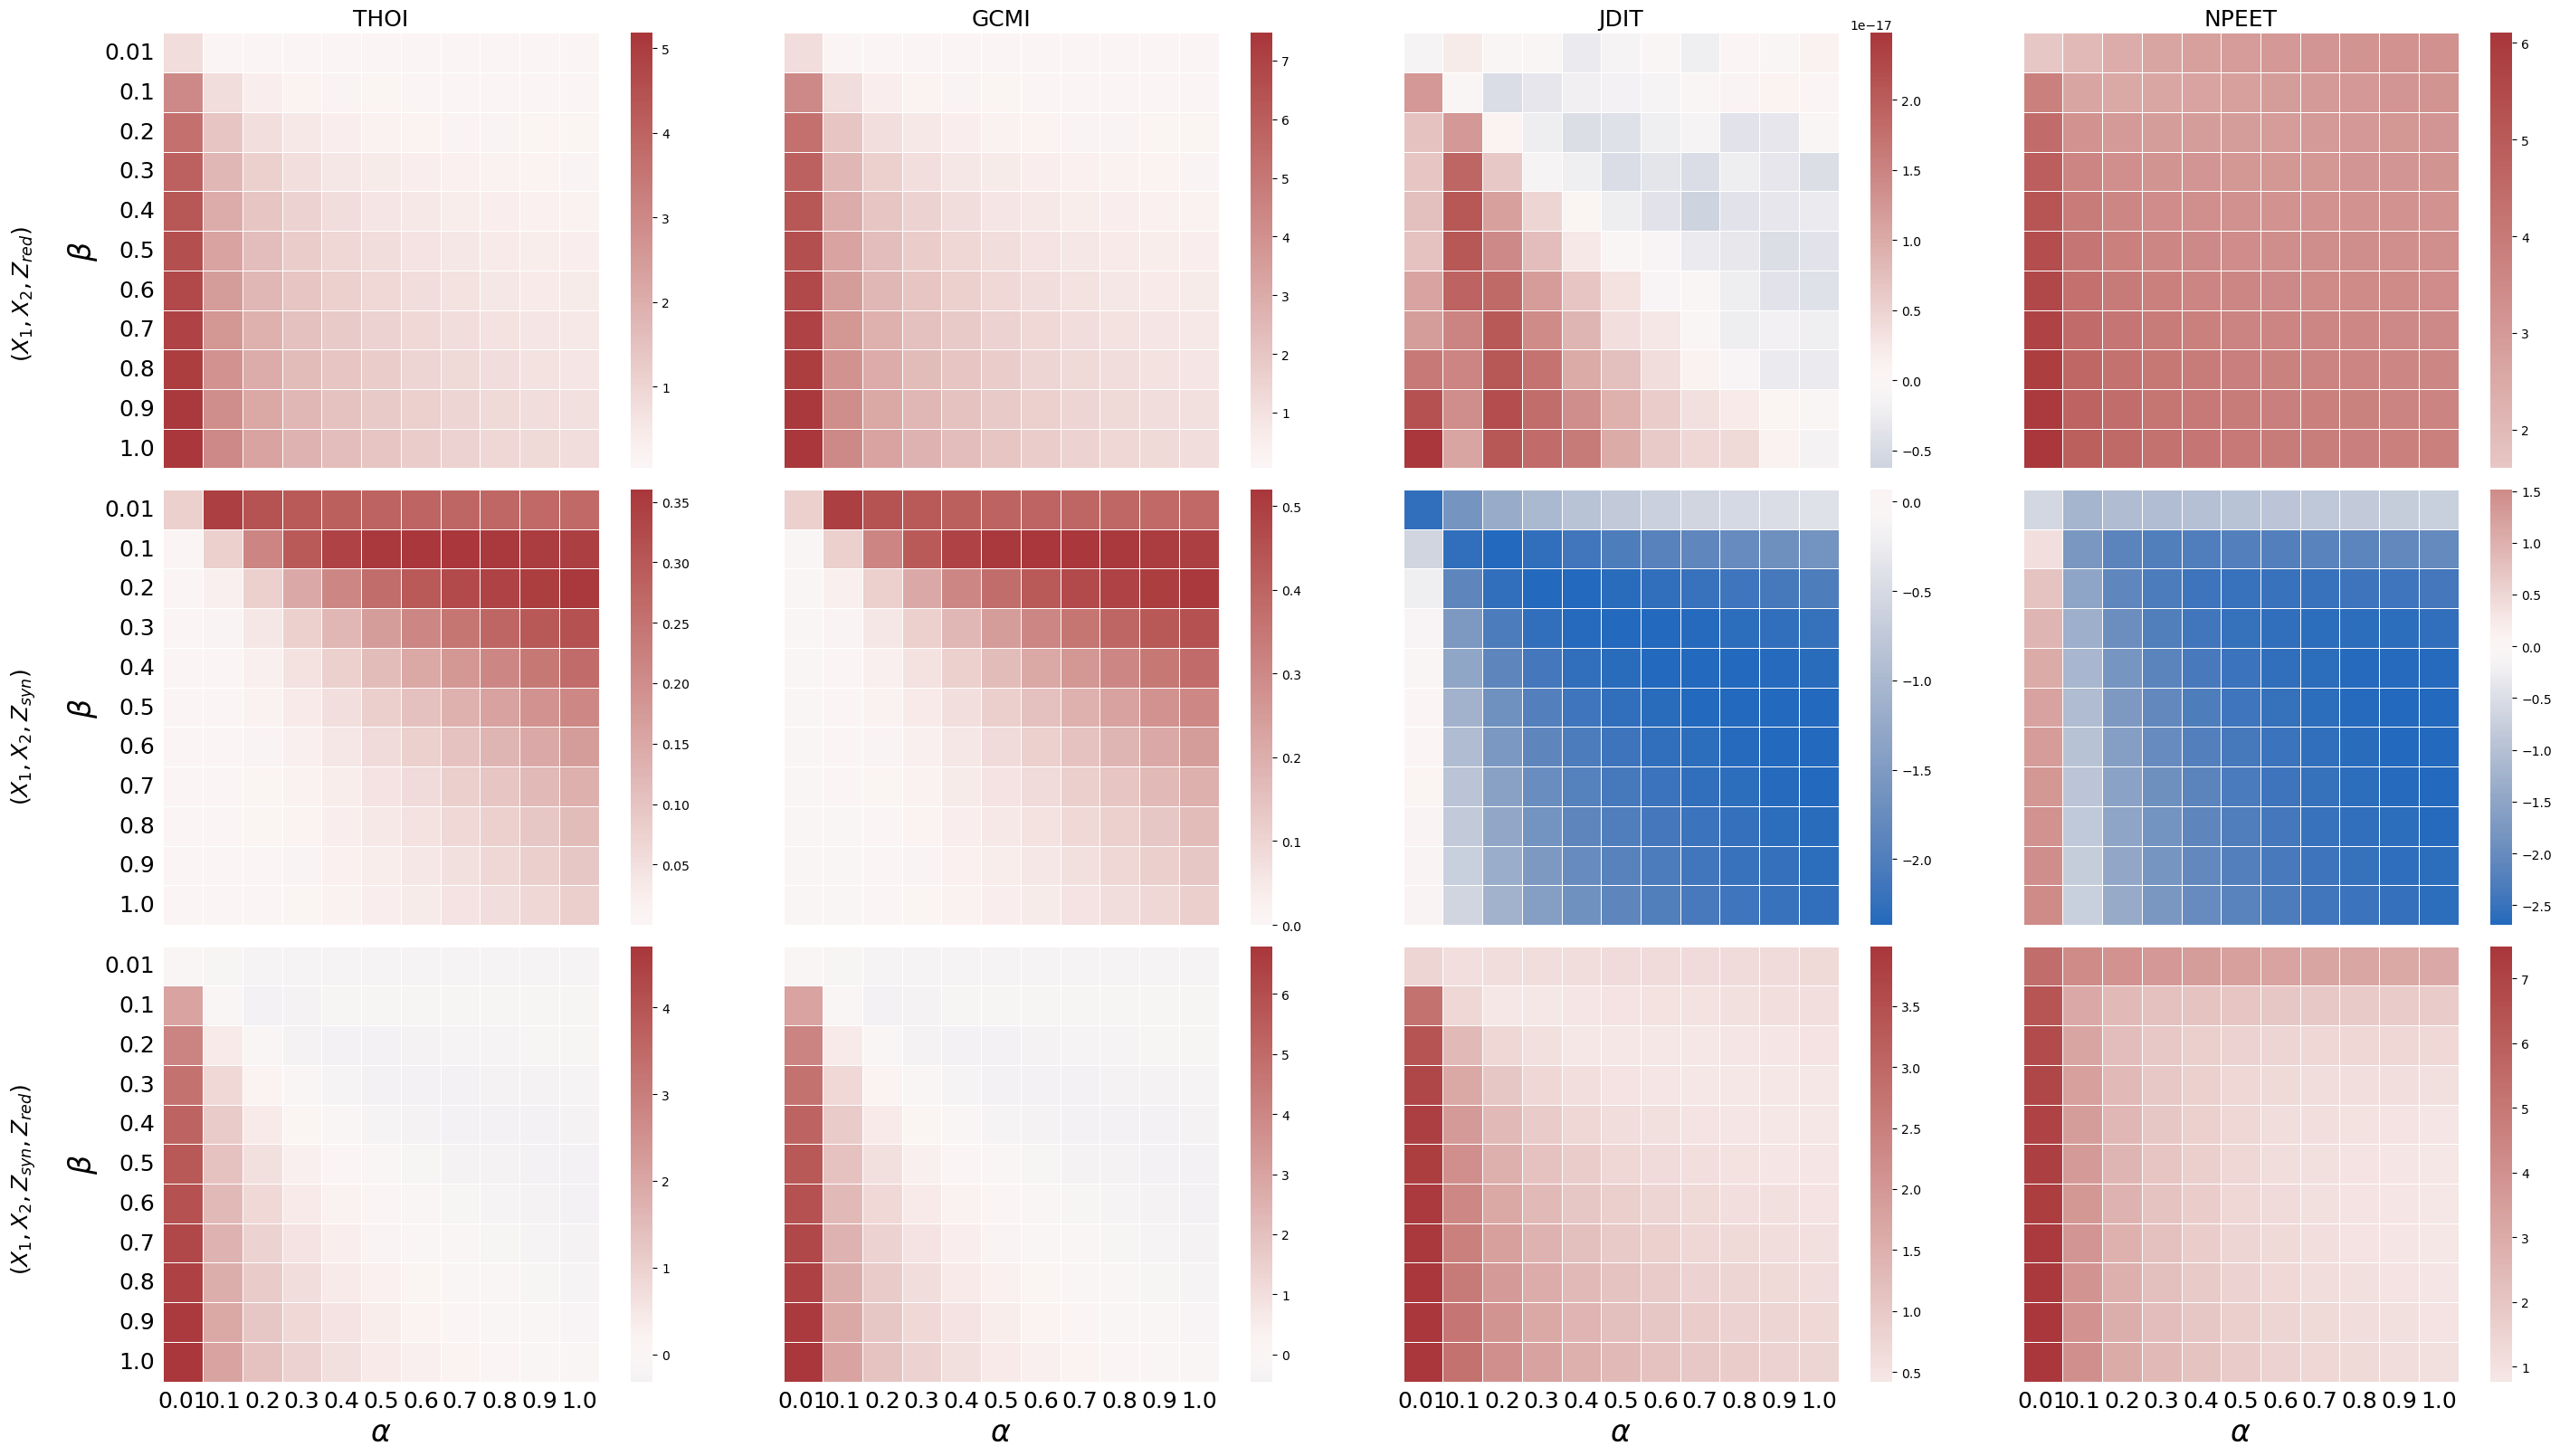

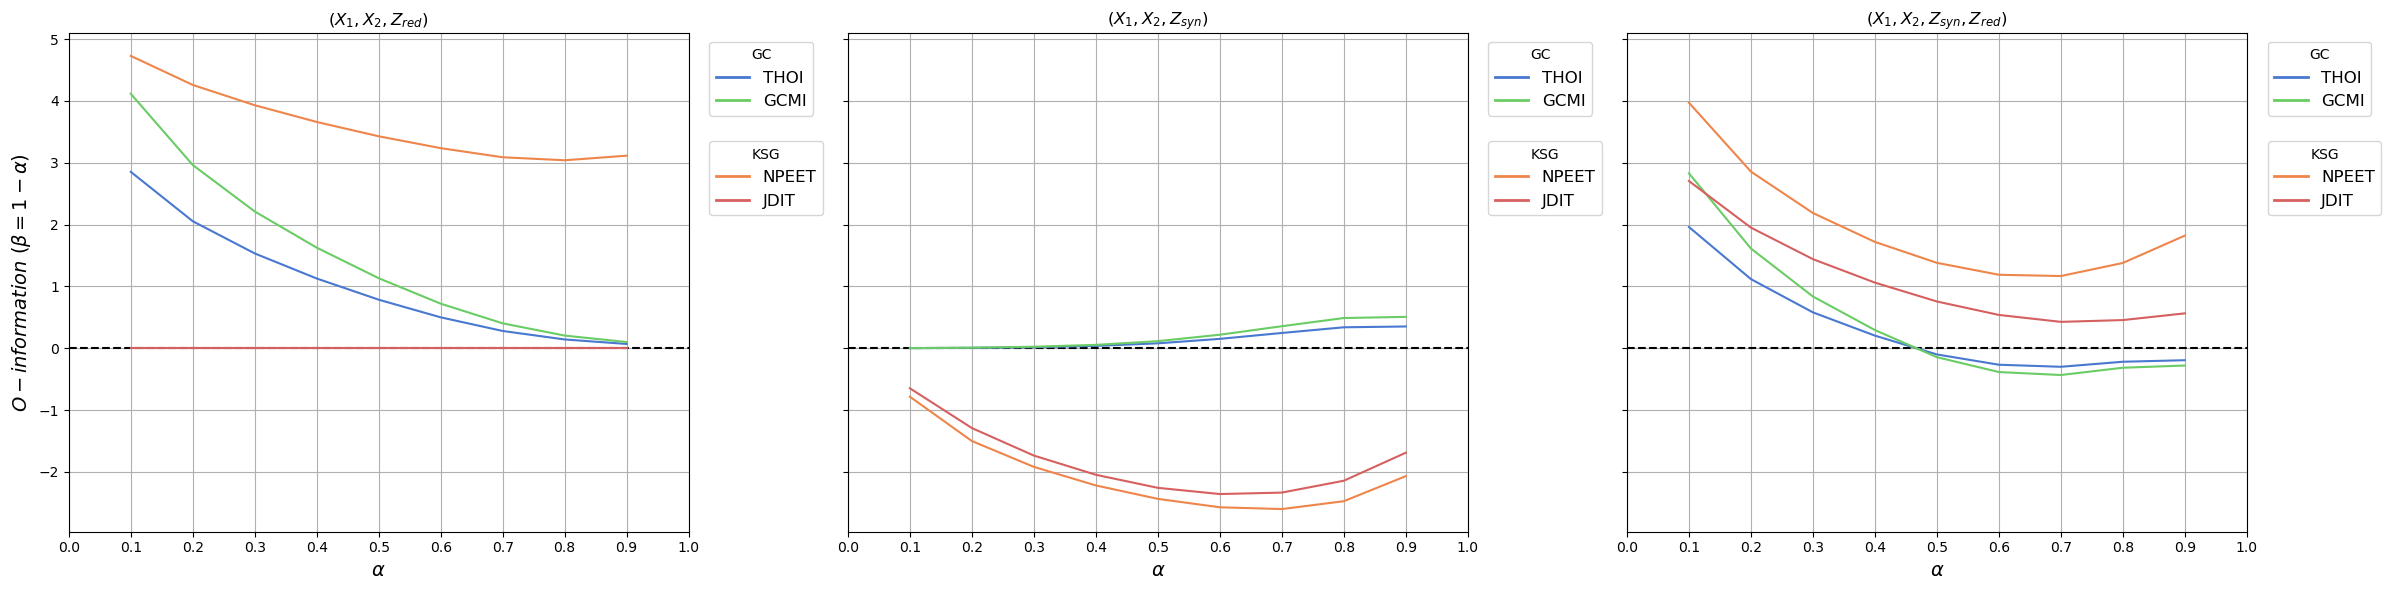

In [3]:
df1 = pd.read_csv('../benchmarking/results/o_info/system-relu_pow-0.5_repeat-20_t-10000.tsv', sep='\t')
df2 = pd.read_csv('../benchmarking/results/o_info/system-relu_pow-0.5_repeat-20_t-10000_JDIT.tsv', sep='\t')

df = pd.concat([df1, df2])

#df = df[(df['beta'] >= 0.095) & (df['beta'] <= 0.905) & (df['alpha'] >= 0.095) & (df['alpha'] <= 0.905)]

plot_o_info_heatmap(df, 'relu_pow-0.5')
plot_o_info_linear(df, 'relu_pow-0.5')

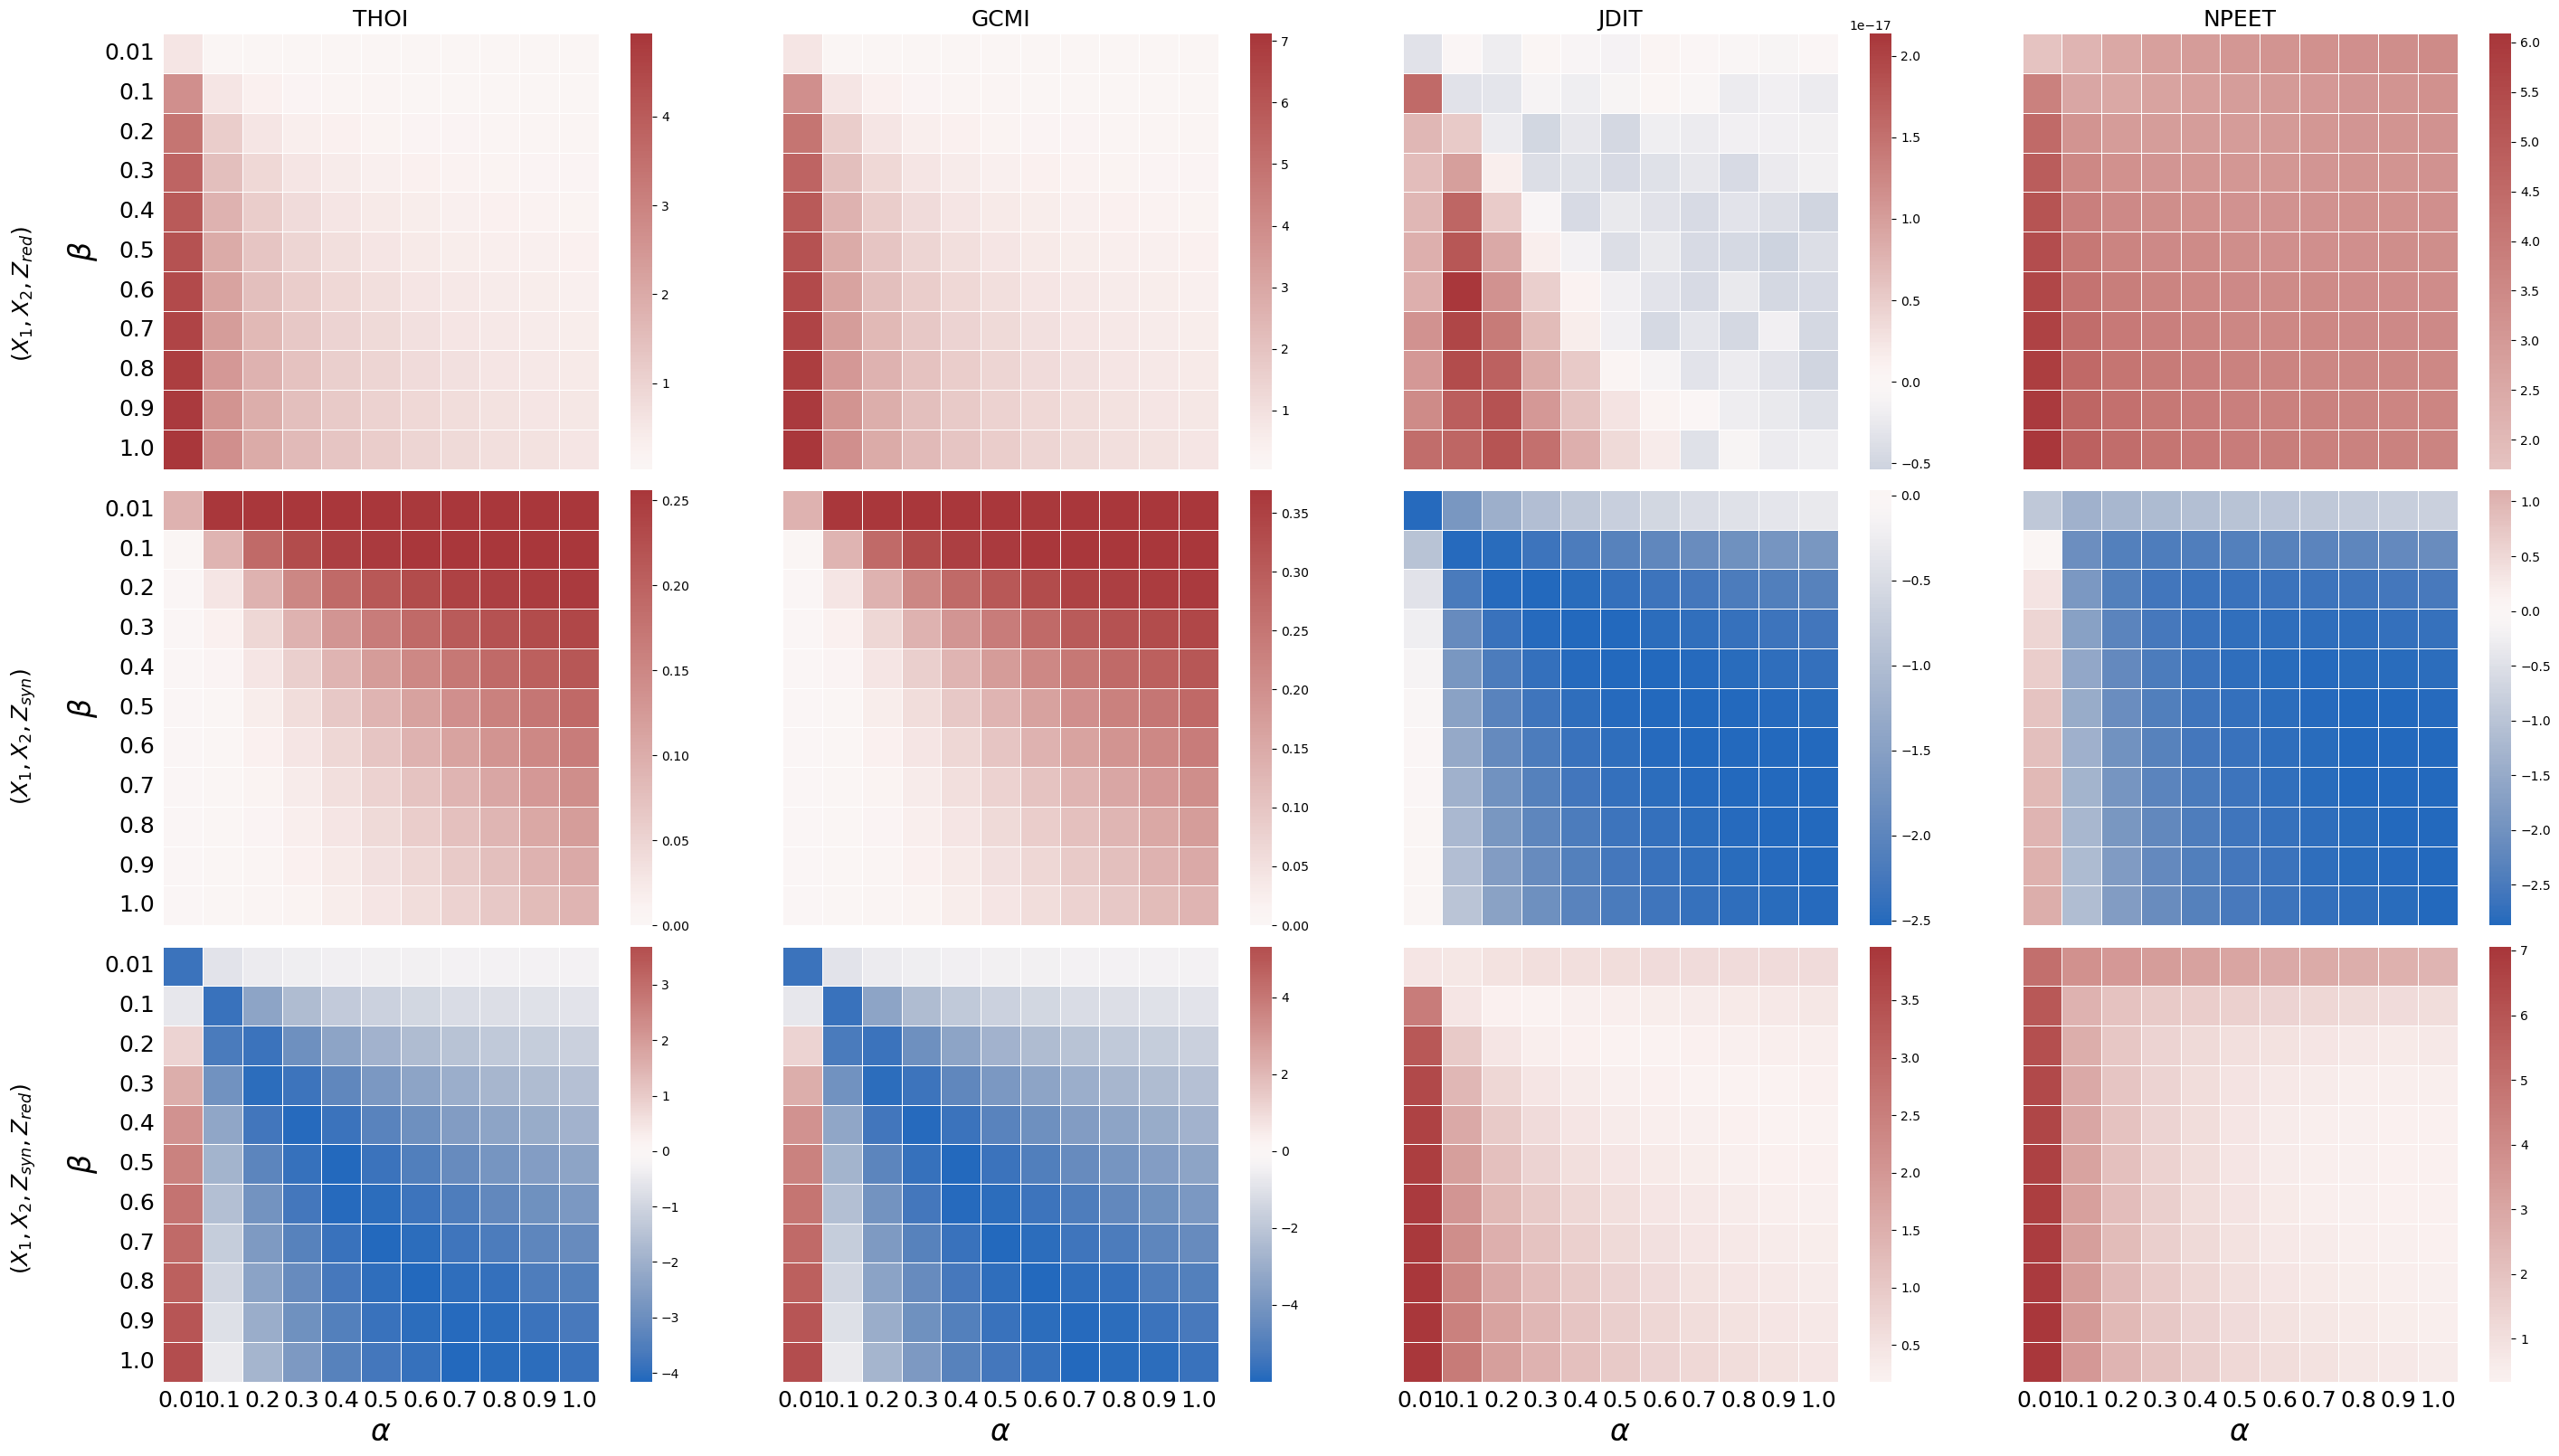

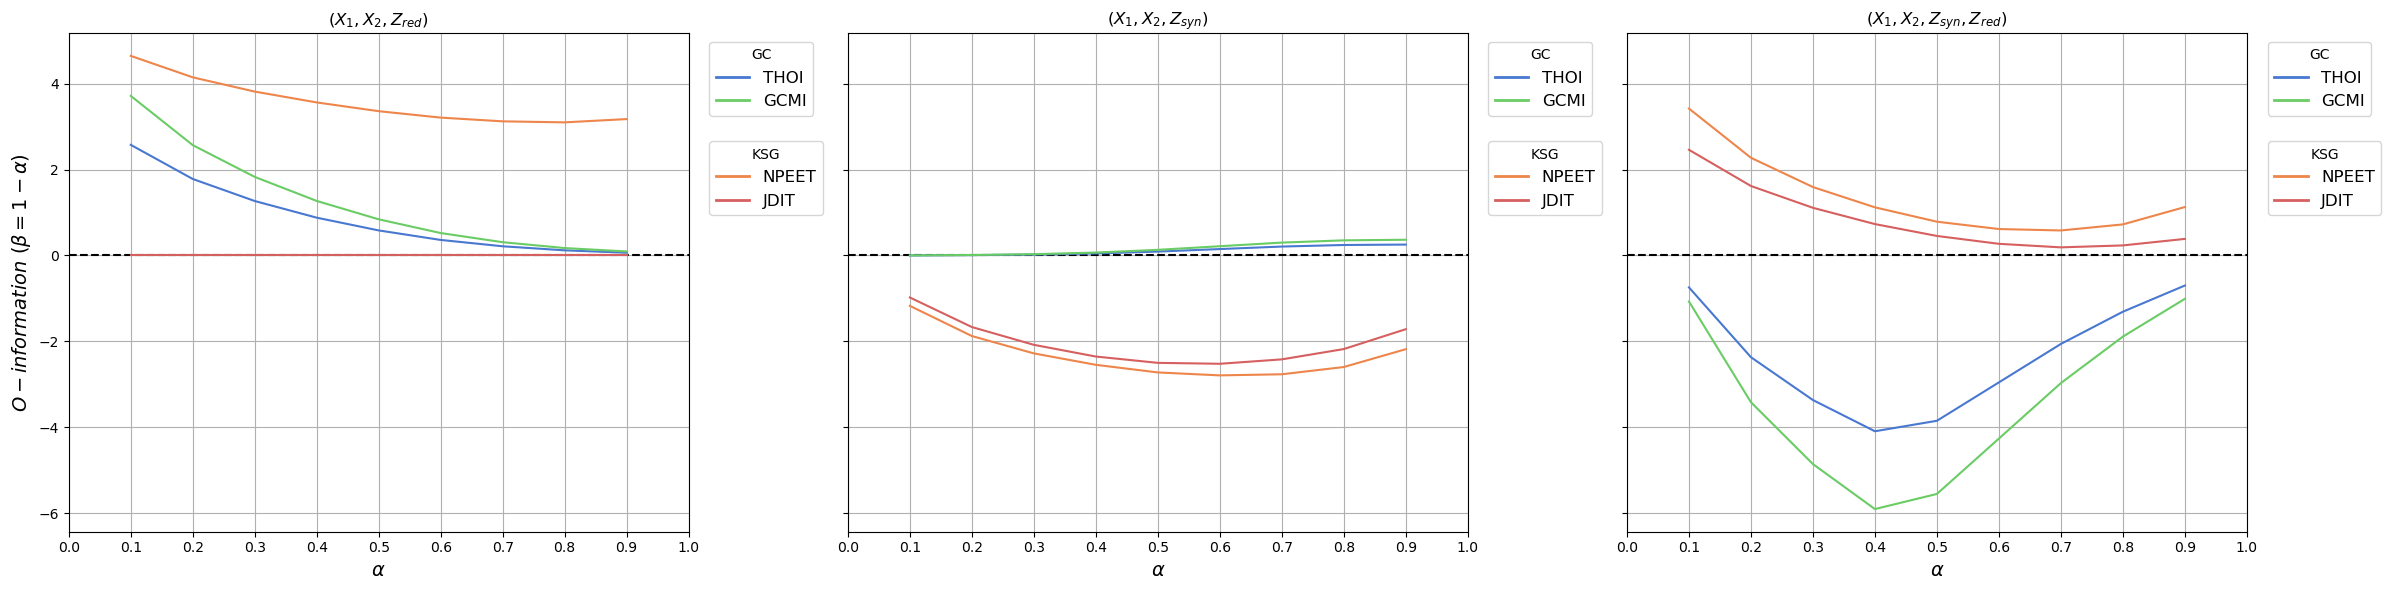

In [4]:
df1 = pd.read_csv('../benchmarking/results/o_info/system-relu_pow-1.0_repeat-20_t-10000.tsv', sep='\t')
df2 = pd.read_csv('../benchmarking/results/o_info/system-relu_pow-1.0_repeat-20_t-10000_JDIT.tsv', sep='\t')

df = pd.concat([df1, df2])

#df = df[(df['beta'] >= 0.095) & (df['beta'] <= 0.905) & (df['alpha'] >= 0.095) & (df['alpha'] <= 0.905)]

plot_o_info_heatmap(df, 'relu_pow-1.0|')
plot_o_info_linear(df, 'relu_pow-1.0')

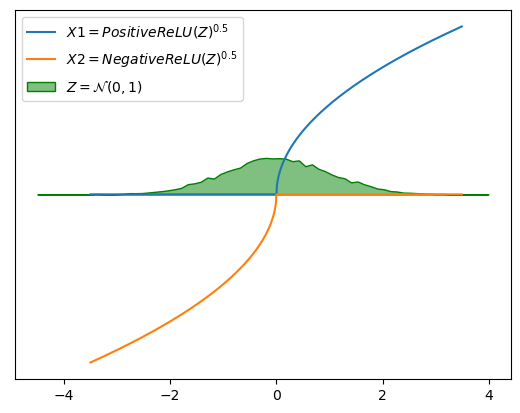

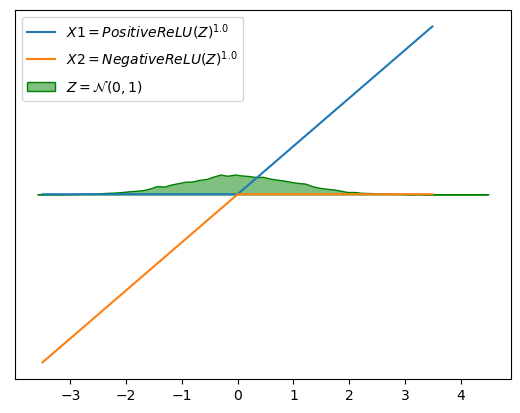

In [5]:
def ReLU(X, cutoff=0):
    return np.maximum(X,cutoff)


def plot_ReLU_system(pow_factor=0.5, ax=None):

    Z = np.arange(-3.5, 3.5, 0.01)
    X1 = np.power(ReLU(Z), pow_factor)
    X2 = -np.power(np.abs(ReLU(-Z)), pow_factor)


    ax = sns.histplot(np.random.normal(0,1,10000), stat='density', element='poly', color='green', alpha=0.5, label=r'$Z = \mathcal{N}(0,1)$', ax=ax)
    sns.lineplot(x=Z, y=X1, label=rf'$X1 = PositiveReLU(Z)^{{ {pow_factor} }}$', ax=ax)
    sns.lineplot(x=Z, y=X2, label=rf'$X2 = NegativeReLU(Z)^{{ {pow_factor} }}$', ax=ax)

    ax.set_ylabel('')
    ax.set_yticks([])


plot_ReLU_system(pow_factor=0.5)
plt.savefig('./figures/systems/system-ReLU_power-0.5.svg', format='svg')
plt.show()

plot_ReLU_system(pow_factor=1.0)
plt.savefig('./figures/systems/system-ReLU_power-1.0.svg', format='svg')
plt.show()

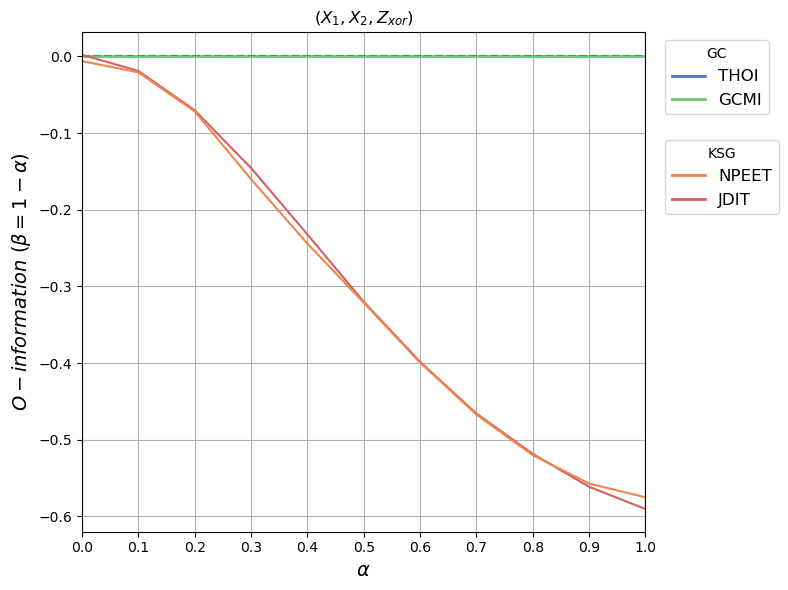

In [6]:
df1 = pd.read_csv('../benchmarking/results/o_info/system-xor_repeat-20_t-10000.tsv', sep='\t')
df2 = pd.read_csv('../benchmarking/results/o_info/system-xor_repeat-20_t-10000_JDIT.tsv', sep='\t')

df = pd.concat([df1, df2])

#df = df[(df['beta'] >= 0.095) & (df['beta'] <= 0.905) & (df['alpha'] >= 0.095) & (df['alpha'] <= 0.905)]

#plot_o_info_heatmap(df, 'xor')
plot_o_info_linear(df, 'xor', remove_beta=False)

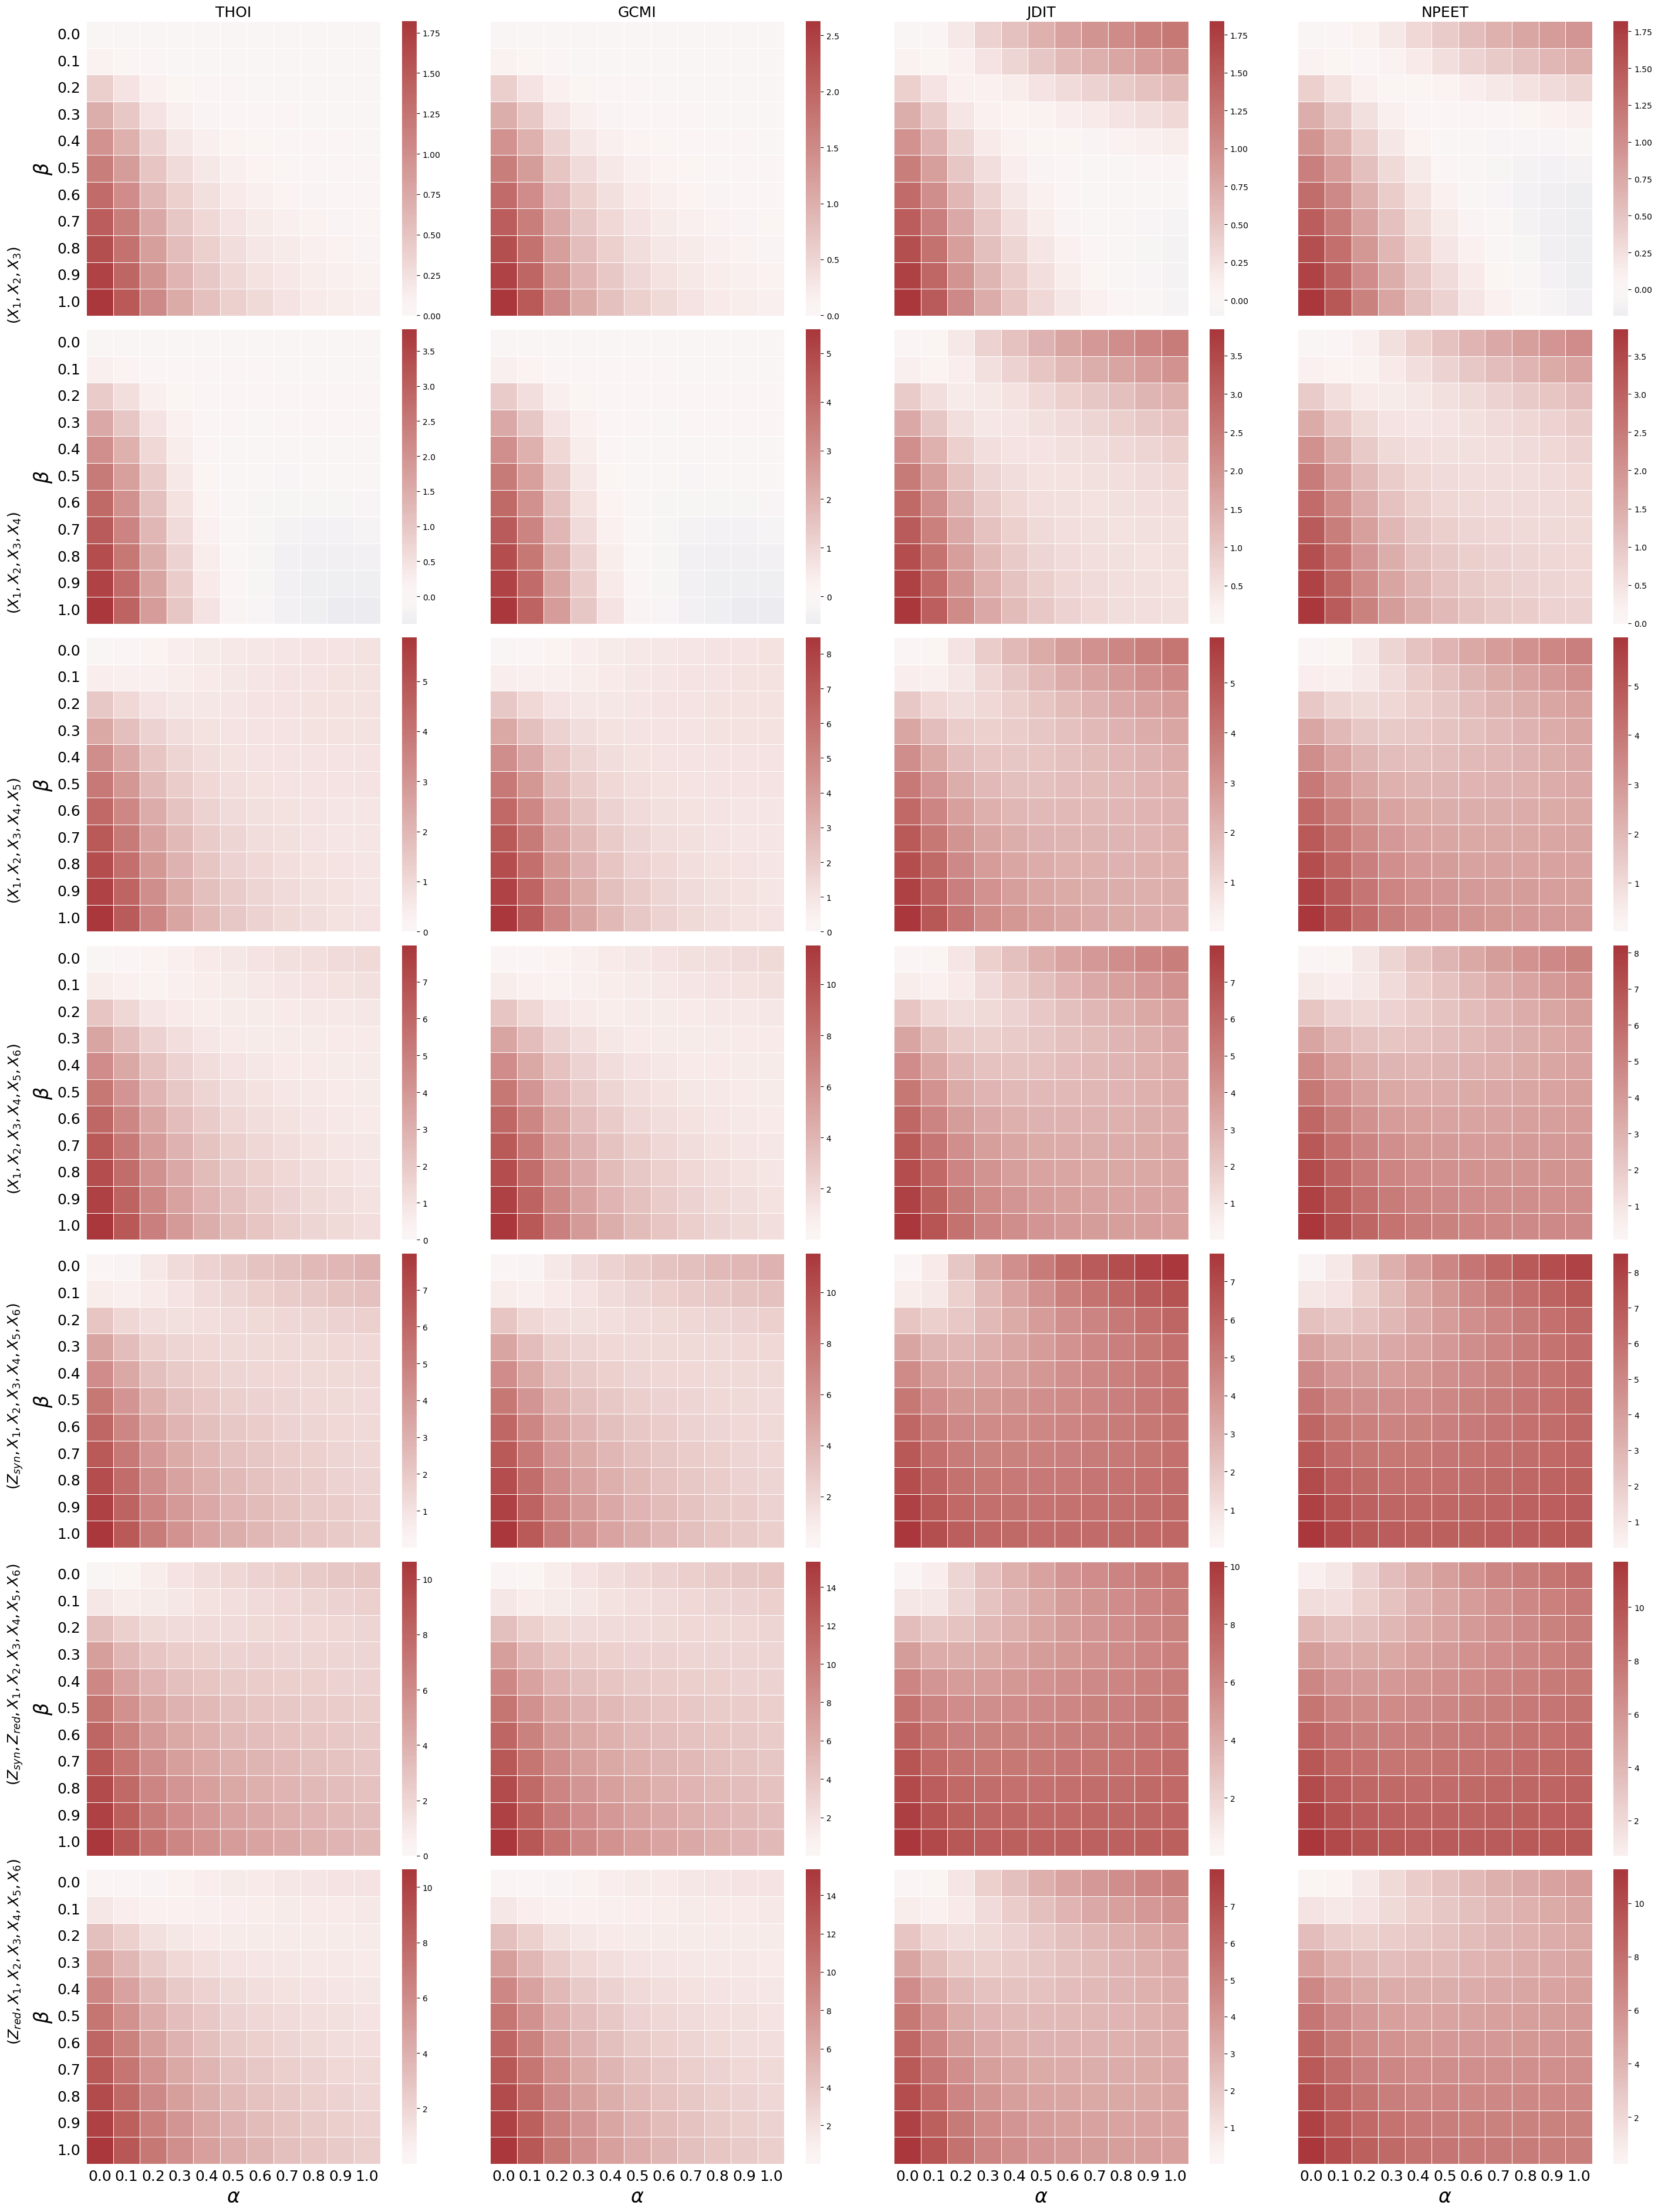

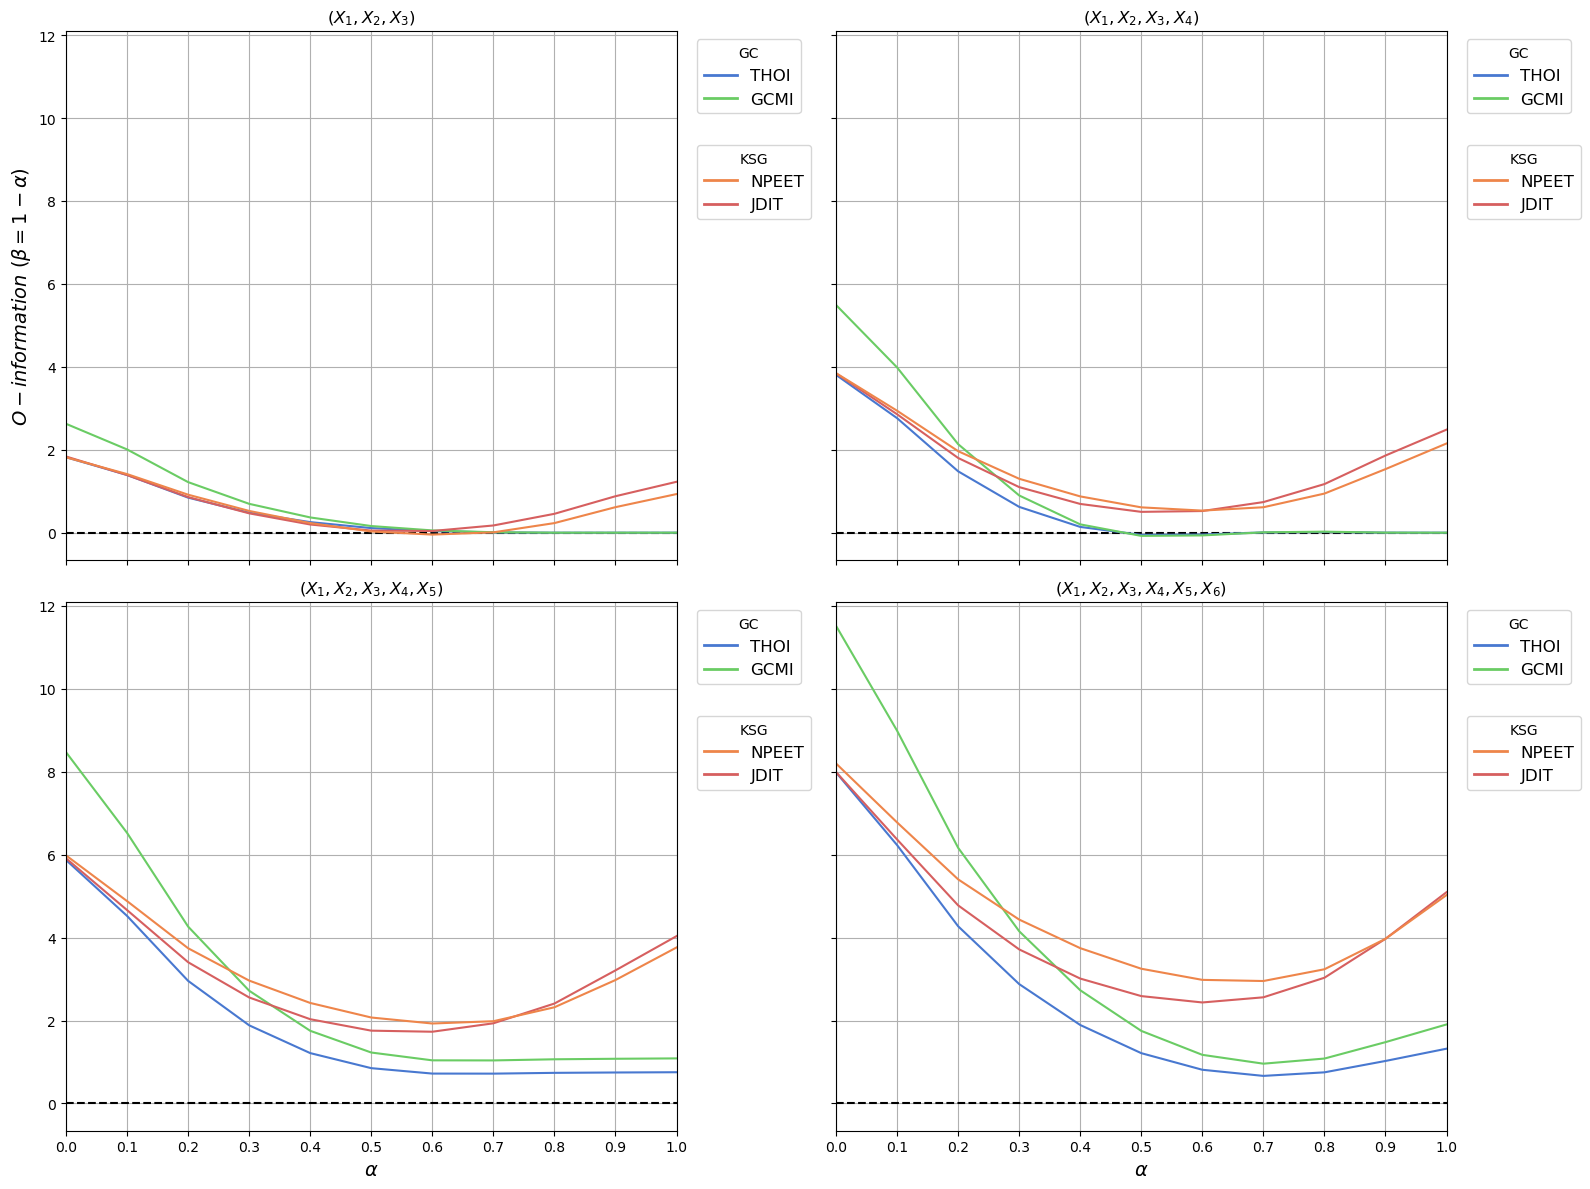

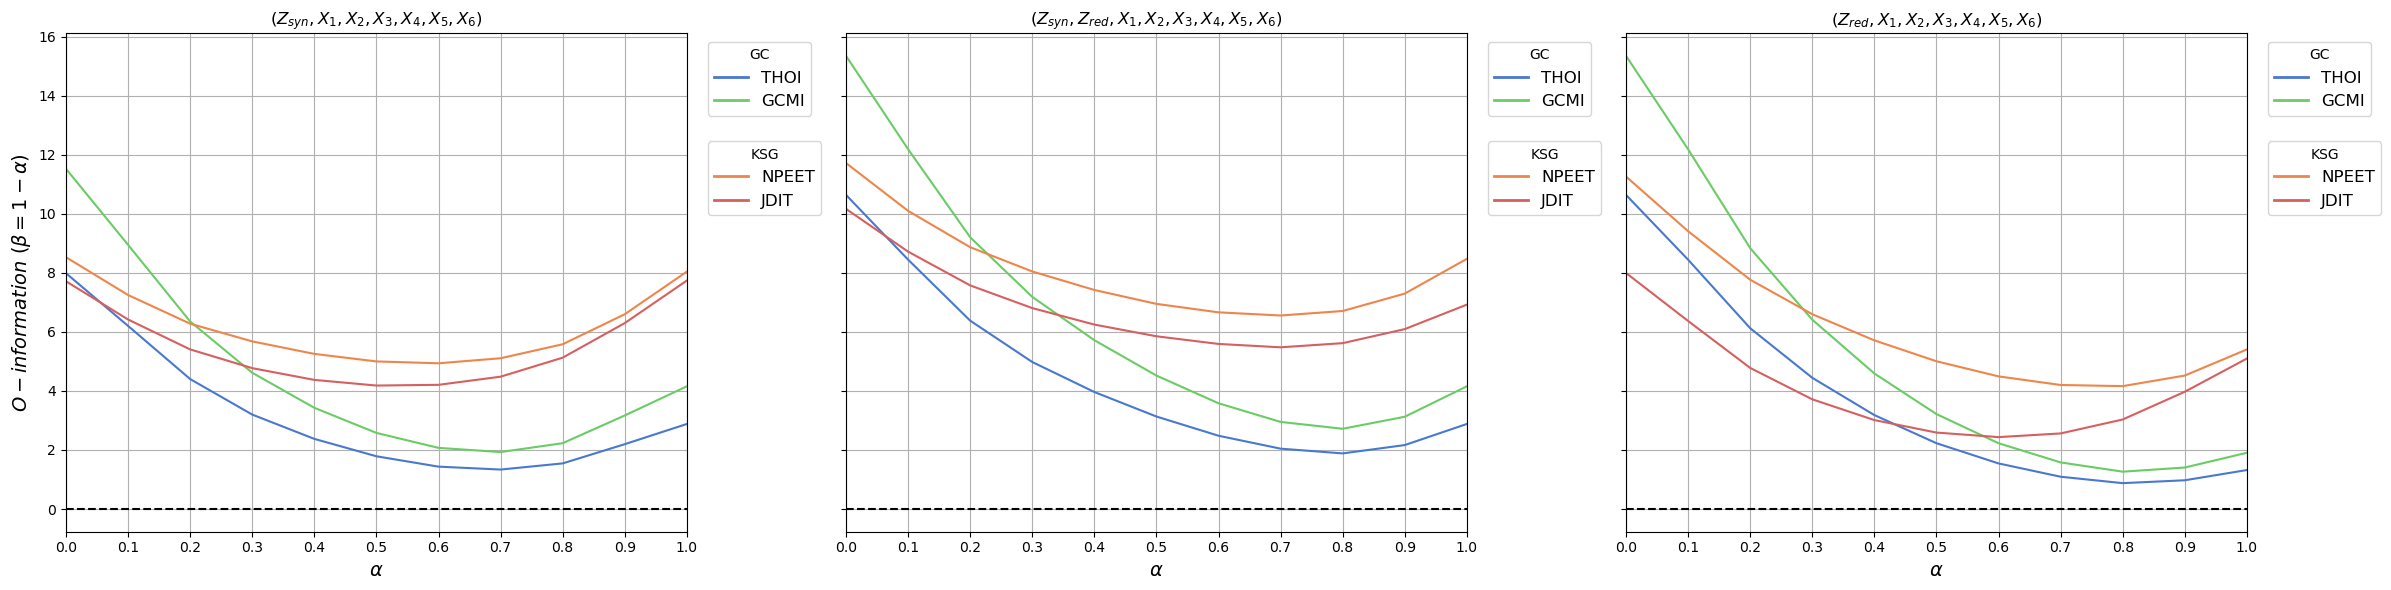

In [11]:
nplets = ['X1-X2-X3','X1-X2-X3-X4','X1-X2-X3-X4-X5','X1-X2-X3-X4-X5-X6','Z01-X1-X2-X3-X4-X5-X6','Z00-X1-X2-X3-X4-X5-X6','Z00-Z01-X1-X2-X3-X4-X5-X6']

df1 = pd.read_csv('../benchmarking/results/o_info/system-flat_repeat-20_t-10000.tsv', sep='\t')
df2 = pd.read_csv('../benchmarking/results/o_info/system-flat_repeat-20_t-10000_JDIT.tsv', sep='\t')

df = pd.concat([df1, df2])

df = df[df.gamma == 0.1]
df = df[df['n-plet'].isin(nplets)]

#df = df[(df['beta'] >= 0.095) & (df['beta'] <= 0.905) & (df['alpha'] >= 0.095) & (df['alpha'] <= 0.905)]

plot_o_info_heatmap(df, 'flat')

nplets = ['X1-X2-X3','X1-X2-X3-X4','X1-X2-X3-X4-X5','X1-X2-X3-X4-X5-X6']
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2*6), sharex=True, sharey=True)
plot_o_info_linear(df[df['n-plet'].isin(nplets)],'flat', axes=axes.flatten())

nplets = ['Z01-X1-X2-X3-X4-X5-X6','Z00-X1-X2-X3-X4-X5-X6','Z00-Z01-X1-X2-X3-X4-X5-X6']
fig, axes = plt.subplots(1, 3, figsize=(3*8, 6), sharex=True, sharey=True)
plot_o_info_linear(df[df['n-plet'].isin(nplets)],'flat', axes=axes.flatten())

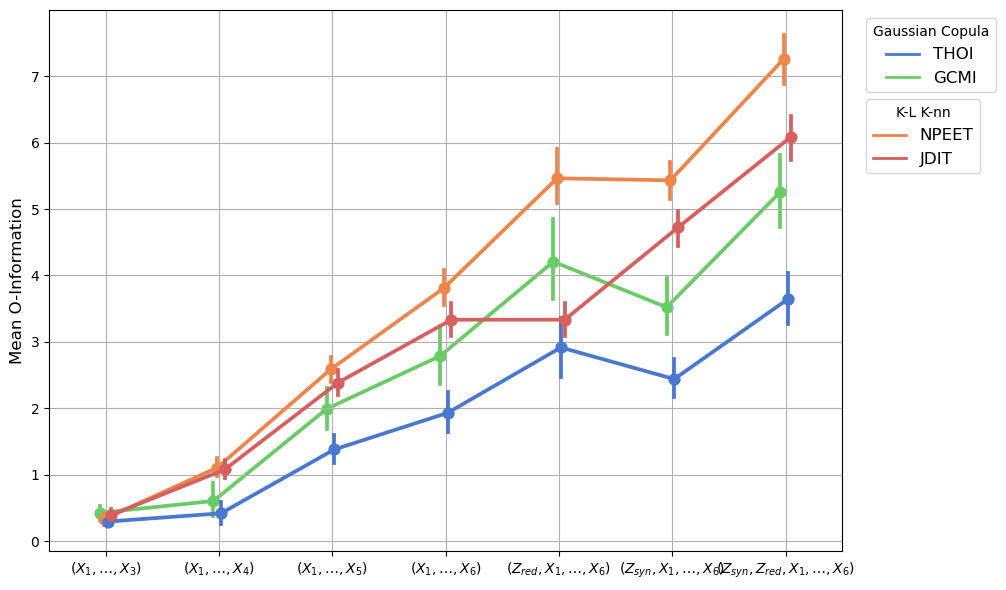

In [8]:
nplet_order = [
    'X1-X2-X3',
    'X1-X2-X3-X4',
    'X1-X2-X3-X4-X5',
    'X1-X2-X3-X4-X5-X6',
    'Z01-X1-X2-X3-X4-X5-X6',
    'Z00-X1-X2-X3-X4-X5-X6',
    'Z00-Z01-X1-X2-X3-X4-X5-X6'
]
nplet_labels = [
    r'$(X_1,\ldots,X_3)$',
    r'$(X_1,\ldots,X_4)$',
    r'$(X_1,\ldots,X_5)$',
    r'$(X_1,\ldots,X_6)$',
    r'$(Z_{red},X_1,\ldots,X_6)$',
    r'$(Z_{syn},X_1,\ldots,X_6)$',
    r'$(Z_{syn},Z_{red},X_1,\ldots,X_6)$'
]

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=df, x='n-plet', y='O-information', hue='method',
    palette=method_colors, order=nplet_order,
    dodge=True, join=True, markers='o'
)

# Customize the plot
# [format_nplet_name(nplet) for nplet in nplet_order]
plt.xticks([0,1,2,3,4,5,6], nplet_labels , fontsize=10)
plt.xlabel('')

plt.ylabel('Mean O-Information', fontsize=12)
plt.title('')

legend_elements_gaussian = [
    Line2D([0], [0], color=method_colors['THOI'], lw=2, label='THOI'),
    Line2D([0], [0], color=method_colors['GCMI'], lw=2, label='GCMI')
]
legend_elements_kl = [
    Line2D([0], [0], color=method_colors['NPEET'], lw=2, label='NPEET'),
    Line2D([0], [0], color=method_colors['JDIT'], lw=2, label='JDIT')
]

l1 = plt.legend(handles=legend_elements_gaussian, title='Gaussian Copula', loc='upper left', fontsize=12, bbox_to_anchor=(1.02, 1))
plt.gca().add_artist(l1)
plt.legend(handles=legend_elements_kl, title='K-L K-nn', loc='upper left', fontsize=12, bbox_to_anchor=(1.02, 0.85))
    
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('./figures/o_info/system-flat_mean_per_nplet_and_method.svg', format='svg')
plt.show()